## Imports

In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.interpolate import BSpline
import numpy as np
import scipy.linalg as la


import jax
import jax.numpy as jnp
from jax.lax.linalg import tridiagonal_solve
from jax import jit
from functools import partial


## Importing Data

In [37]:
data_dir = "./data/DopantUptake/DopantUptake/Data"
samples = [os.path.join(data_dir, sample) for sample in os.listdir(data_dir)]


sample_dfs = {}
for sample in samples:
    sample_name = os.path.basename(sample).split('.')[0]
    sample_dfs[sample_name] = pd.read_csv(sample, sep='\t', skiprows=1, na_values=["Failed"])

def sorter(item):
    if item[0].startswith('Sample'):
        return int(item[0].split(' ')[-1])
    else: return 0

sample_dfs = dict( sorted(sample_dfs.items(), key=sorter) )

In [3]:
sample_dfs.keys()

dict_keys(['Reference_bare sensor 1', 'Reference_bare sensor 2', 'Reference_bare sensor 3', 'Sample 1', 'Sample 2', 'Sample 3', 'Sample 12', 'Sample 15', 'Sample 21', 'Sample 22', 'Sample 23', 'Sample 24', 'Sample 39', 'Sample 50', 'Sample 53', 'Sample 58', 'Sample 61', 'Sample 80', 'Sample 81'])

In [4]:
sample_dfs['Sample 12']

,Time [s],R2_m9 [ng/cm^2],C1_m [ng/cm^2]
0,0.0000,NaN,NaN
1,1.3259,NaN,NaN
2,2.6424,NaN,NaN
3,3.9720,NaN,NaN
4,5.3007,NaN,NaN
...,...,...,...
4395,1764.2580,749.44,749.82
4396,1764.6506,754.17,751.57
4397,1765.0690,752.55,749.63
4398,1765.5342,751.58,750.93


## Plotting Data

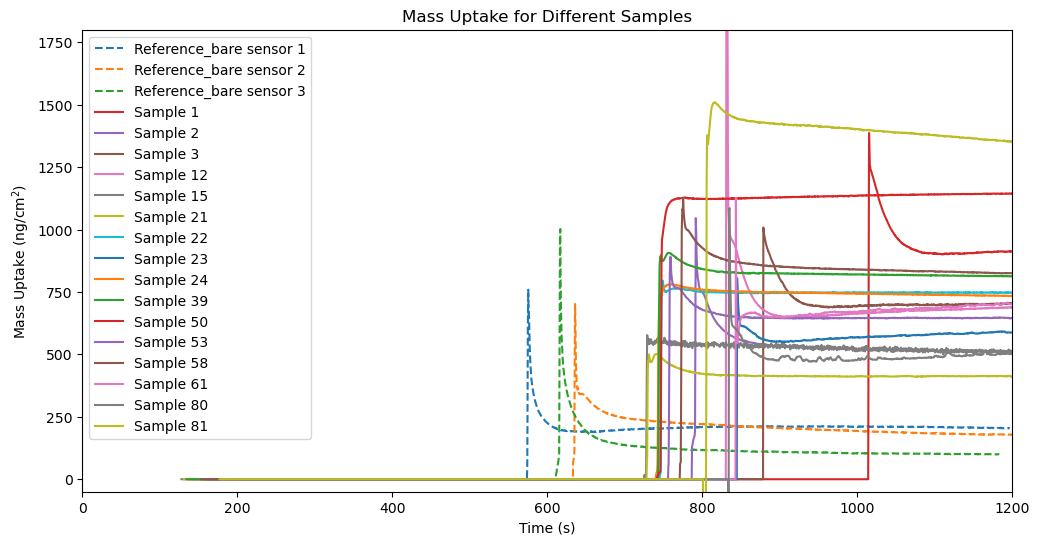

In [23]:
plt.figure(figsize=(12, 6))
plt.title('Mass Uptake for Different Samples')
plt.xlabel('Time (s)')
plt.ylabel('Mass Uptake (ng/cm$^2$)')

for sample_name in sample_dfs:
    if sample_name.startswith('Sample'): linestyle = '-'
    else: linestyle = '--'
    t = sample_dfs[sample_name]['Time [s]']
    m = sample_dfs[sample_name]['C1_m [ng/cm^2]']
    plt.plot(t, m, label=sample_name, linestyle=linestyle)


plt.xlim(0, 1200)
plt.ylim(-50, 1800)
plt.legend()

## Isolating Uptakes

### Grouped by highest dm/dt

In [ ]:
cropped_sample_dfs_highest = {}
df_list = []

for sample_name in sample_dfs:

    sample_df = sample_dfs[sample_name]
    sample_df = sample_df.dropna()

    # Find middle of uptake
    t = sample_df['Time [s]']
    m = sample_df['C1_m [ng/cm^2]']

    sample_df['dm/dt'] = jnp.gradient(m, t)

    idx_max = int( sample_df['dm/dt'].idxmax() )

    df_cropped = sample_df.loc[(idx_max-5):(idx_max+10)]

    t0 = df_cropped.loc[idx_max, 'Time [s]']
    df_cropped['Time shifted [s]'] = df_cropped['Time [s]'] - t0

    df_cropped = df_cropped.reset_index(drop=True)
    
    # Set up this part of the combined df
    temp = df_cropped[['Time shifted [s]', 'C1_m [ng/cm^2]']].copy()
    temp = temp.rename(columns={'C1_m [ng/cm^2]': sample_name})
    temp = temp.set_index('Time shifted [s]')
    df_list.append(temp)

    # Add cropped sample df to dict
    cropped_sample_dfs_highest[sample_name] = df_cropped

merged_df = pd.concat(df_list, axis=1) # concatenate all along columns, automatically aligns on index/time. If no data for that time in a given column, NaN entered.
merged_df = merged_df.sort_index()
merged_df = merged_df.groupby(merged_df.index).first() # Remove duplicate times/associated NaNs

C:\Users\willi\AppData\Local\Temp\ipykernel_3116\1101613382.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['dm/dt'] = np.gradient(m, t)
C:\Users\willi\AppData\Local\Temp\ipykernel_3116\1101613382.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cropped['Time shifted [s]'] = df_cropped['Time [s]'] - t0
C:\Users\willi\AppData\Local\Temp\ipykernel_3116\1101613382.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [44]:
merged_df

,Reference_bare sensor 1,Reference_bare sensor 2,Reference_bare sensor 3,Sample 1,Sample 2,Sample 3,Sample 12,Sample 15,Sample 21,Sample 22,Sample 23,Sample 24,Sample 39,Sample 50,Sample 53,Sample 58,Sample 61,Sample 80,Sample 81
Time shifted [s],,,,,,,,,,,,,,,,,,,
-3.0976,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2.6948,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2.5440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2.4190,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2.3158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.7699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780.09,NaN,NaN,NaN,NaN
4.7950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,613.09,NaN
4.8216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1043.66,NaN,NaN,NaN,NaN,NaN


In [39]:
# Check

for col in list(merged_df.columns):
    print(merged_df[col].count())

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


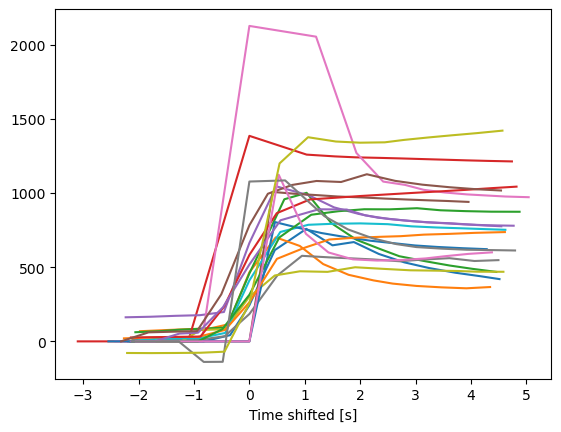

In [50]:
for col in list(merged_df.columns):
    merged_df[col].dropna().plot()

In [ ]:
cropped_sample_dfs_highest.keys()

dict_keys(['Reference_bare sensor 1', 'Reference_bare sensor 2', 'Reference_bare sensor 3', 'Sample 1', 'Sample 2', 'Sample 3', 'Sample 12', 'Sample 15', 'Sample 21', 'Sample 22', 'Sample 23', 'Sample 24', 'Sample 39', 'Sample 50', 'Sample 53', 'Sample 58', 'Sample 61', 'Sample 80', 'Sample 81'])

In [ ]:
len(cropped_sample_dfs_highest)

19

In [ ]:
cropped_sample_dfs_highest['Sample 2']

,Time [s],R1_m5 [ng/cm^2],C1_m [ng/cm^2],dm/dt,Time shifted [s]
0,788.7621,159.89,162.43,10.573461,-2.2330
1,789.2139,165.75,166.18,11.000616,-1.7812
2,789.6663,172.60,172.38,11.775053,-1.3288
3,790.1044,176.80,176.72,29.940592,-0.8907
4,790.5357,182.49,198.14,516.270839,-0.4594
5,790.9951,592.01,663.64,903.325806,0.0000
6,791.4806,1060.09,1045.79,385.726374,0.4855
7,792.0720,1007.71,984.74,-146.321361,1.0769
8,792.5237,923.96,903.78,-139.038109,1.5286
9,792.9692,876.88,859.50,-84.628283,1.9741


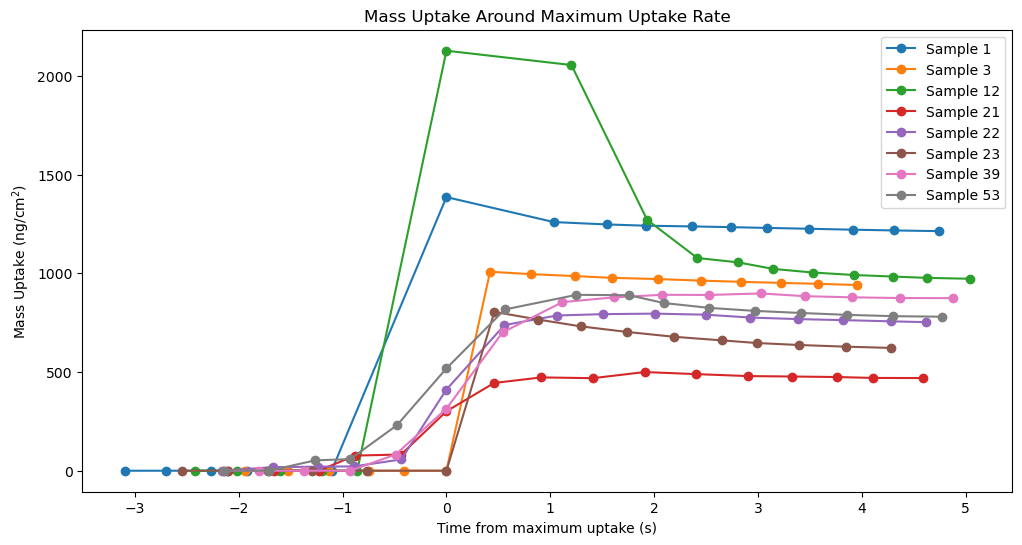

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Mass Uptake Around Maximum Uptake Rate')
plt.xlabel('Time from maximum uptake (s)')
plt.ylabel('Mass Uptake (ng/cm$^2$)')

for sample_name in list(cropped_sample_dfs_highest.keys())[:15]:
    if sample_name.startswith('Sample'): 
        df_cropped = cropped_sample_dfs_highest[sample_name]
        if df_cropped.loc[0,'m'] < 1:
            plt.plot(df_cropped['t shifted'], df_cropped['m'], marker='o', linestyle='-', label=sample_name)

plt.legend()

### Grouped by initial uptake

In [38]:
cropped_sample_dfs_first = {}

for sample_name in sample_dfs:

    sample_df = sample_dfs[sample_name]
    sample_df = sample_df.dropna()


    idx_first = sample_df.loc[sample_df['C1_m [ng/cm^2]'] != 0].index[0] # Isolates the first nonzero uptake


    df_cropped = sample_df.loc[(idx_first-5):(idx_first+15)]

    t0 = df_cropped.loc[idx_first-1, 'Time [s]']  # Make t=0 the first point BEFORE any uptake is detected
    df_cropped['Time shifted [s]'] = df_cropped['Time [s]'] - t0

    df_cropped = df_cropped.reset_index(drop=True)
    

    cropped_sample_dfs_first[sample_name] = df_cropped
    

C:\Users\willi\AppData\Local\Temp\ipykernel_22608\709114923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cropped['Time shifted [s]'] = df_cropped['Time [s]'] - t0
C:\Users\willi\AppData\Local\Temp\ipykernel_22608\709114923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cropped['Time shifted [s]'] = df_cropped['Time [s]'] - t0
C:\Users\willi\AppData\Local\Temp\ipykernel_22608\709114923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [111]:
cropped_sample_dfs_first.keys()

dict_keys(['Reference_bare sensor 1', 'Reference_bare sensor 2', 'Reference_bare sensor 3', 'Sample 1', 'Sample 2', 'Sample 3', 'Sample 12', 'Sample 15', 'Sample 21', 'Sample 22', 'Sample 23', 'Sample 24', 'Sample 39', 'Sample 50', 'Sample 53', 'Sample 58', 'Sample 61', 'Sample 80', 'Sample 81'])

In [112]:
cropped_sample_dfs_first['Sample 2']

,Time [s],R1_m5 [ng/cm^2],C1_m [ng/cm^2],Time shifted [s]
0,784.4969,0.00,0.00,-1.7137
1,784.8411,0.00,0.00,-1.3695
2,785.2929,0.00,0.00,-0.9177
3,785.7706,0.00,0.00,-0.4400
4,786.2106,0.00,0.00,0.0000
5,786.6689,129.86,130.02,0.4583
6,787.0951,135.30,136.08,0.8845
7,787.5232,146.60,144.26,1.3126
8,787.9684,151.61,151.42,1.7578
9,788.3119,156.44,156.65,2.1013


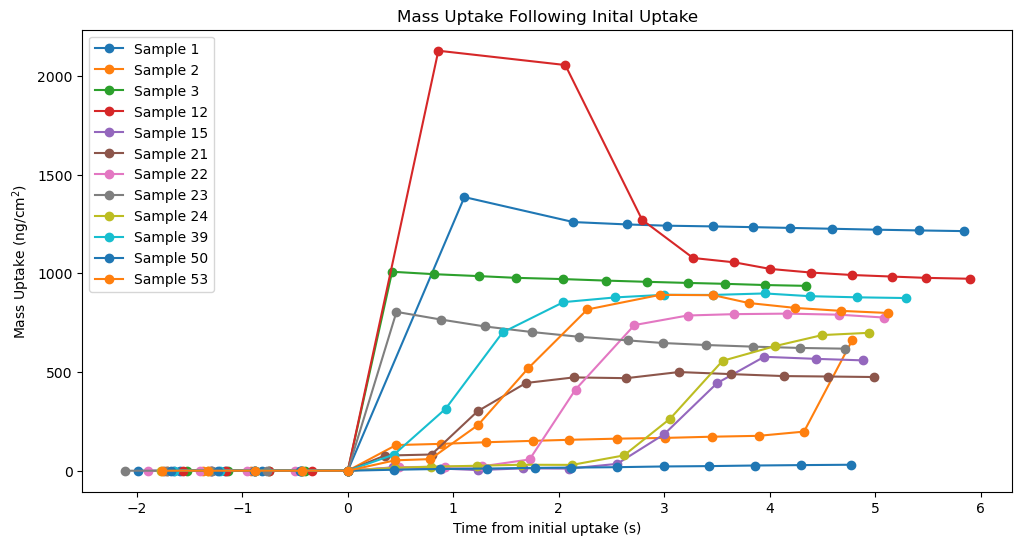

In [113]:
plt.figure(figsize=(12, 6))
plt.title('Mass Uptake Following Inital Uptake')
plt.xlabel('Time from initial uptake (s)')
plt.ylabel('Mass Uptake (ng/cm$^2$)')

for sample_name in list(cropped_sample_dfs_first.keys())[:15]:
    if sample_name.startswith('Sample'): 
        df_cropped = cropped_sample_dfs_first[sample_name]
        if df_cropped.loc[0,'C1_m [ng/cm^2]'] < 1:
            plt.plot(df_cropped['Time shifted [s]'], df_cropped['C1_m [ng/cm^2]'], marker='o', linestyle='-', label=sample_name)

plt.legend()

## Analytic Solution for Given Boundary Conditions

### Background

$$
\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2}
$$
#### Boundary Conditions

**Top (x=0):**

 - Inhomogeneous Dirichlet

 - $C(0, t) = C_0$

 - Drop on polymer surface provides effectively constant concentration at the top boundary.

**Bottom (x=L):**

 - Neumann

 - $\frac{\partial C}{\partial x} \left(L, t \right) = 0$

 - Gold cathode on top of the quartz prevents flux through the lower boundary of the polymer.

  #### Initial Conditions

 - $C(x, t_0) = 0 $

 #### Shifted Solution

 To recover homogeneous boundary conditions, shift the solution by $C_0$ (i.e., a function that obeys the boundary conditions, $w(x,t) = C_0$).

 $$
 u(x,t) = C(x,t) - C_0
 $$

 #### Separation of Variables

 $$
 
 u(x, t) = X(x)T(t)

 \\[1em]

 X(x)T'(t) = D X''(x)T(t)

 \\[1em]

 \frac{T'}{DT} = \frac{X''}{X} \equiv -\lambda

 \\[1em]

 T'(t) + D \lambda T(t) = 0, \qquad X''(x) + \lambda X(x) = 0

 $$

 #### Spatial Eigenvalue Problem

 $$
 X'' + \lambda X = 0
 $$

 **Solution:**

 $$
 X(x) = A \sin(\sqrt{\lambda}x) + B \cos(\sqrt{\lambda} x)
 $$

 Apply boundary conditions to solve for A and B. 

 **Top (Dirichlet Condition):** 

 $$
 X(0) = 0 \rightarrow B = 0
 $$

**Bottom (Neumann Condition):**

$$

X'(x) = A\sqrt{\lambda} \cos(\sqrt{\lambda} x)

\\[1em]

X'(L) = cos(\sqrt{\lambda} L) 

\\[1em]

cos(\sqrt{\lambda} L) = 0

\\[1em]

\sqrt{\lambda} L = (m+1/2)\pi, \qquad m = 0, 1, 2,...

$$

#### Time ODE

$$
T'_m (t) + D \lambda_m T_m(t) = 0
$$

**Solutions:**

$$
T_m(t) = e^{-D \lambda_m t}
$$

#### General Solution

$$

u(x, t) = \sum_{m=0}^\infty a_m \sin(\sqrt{\lambda_m}x) e^{-D \lambda_m t}

\\[1em]

C(x, t) = C_0 + \sum_{m=0}^\infty a_m \sin(\sqrt{\lambda_m}x) e^{-D \lambda_m t}

\\[1em]

\lambda_m = \left( \frac{(m+1/2)\pi}{L} \right)^2

\\[1em]

a_m = \frac{2}{L} \int_0^L (C(x,t_0) - C_0) \sin(\sqrt{\lambda_m} x) dx

\\[1em]

a_m = \frac{-2C_0}{L} \int_0^L \sin(\sqrt{\lambda_m} x) dx

\\[1em]

a_m = \frac{-2C_0 }{L \sqrt{\lambda_m}} 
$$

### Implementation

In [42]:
def analytic_grid(C0, D, L, tf, Nx=500, Nt=500, M=500):
    '''
    Computes the analytic solution to the diffusion equation for the given boundary and initial conditions.
    Returns solution as an array of format C[t, x] and size (Nt, Nx).
    '''
    t = jnp.linspace(0, tf, Nt)
    x = jnp.linspace(0, L, Nx)
    
    T, X = jnp.meshgrid(t,x, indexing='ij')

    C = jnp.full((Nt, Nx), C0, dtype='float')

    for m in jnp.arange(M):
        lambda_m = ( (m+0.5)*jnp.pi / L )**2
        a_m = -(2*C0) / (L*jnp.sqrt(lambda_m))
        C += a_m*jnp.sin(jnp.sqrt(lambda_m)*X)*jnp.exp(-D*lambda_m*T)

    return C

def an_uptake(C0, D, L, times, Nx=500, M=500):
    '''
    Computes the analytic solution to the diffusion equation for the given boundary and initial conditions.
    Computes the mass uptake at all times in the ijnput vector t for comparison.

    C0: Initial concentration of the solvent drop [ng/cm^3]
    D: Diffusion coefficient [cm^2/s]
    L: Film thickness [cm]
    times: different time points [s]
    '''
    
    x = jnp.linspace(0, L, Nx) # [cm]
    dx = L/Nx  # [cm]

    uptakes = []

    for t in times:

        C = jnp.full(Nx, C0, dtype='float')

        for m in jnp.arange(M):
            lambda_m = ( (m+0.5)*jnp.pi / L )**2
            a_m = -(2*C0) / (L*jnp.sqrt(lambda_m))
            C += a_m*jnp.sin(jnp.sqrt(lambda_m)*x)*jnp.exp(-D*lambda_m*t)

        uptakes.append( jnp.sum(C*dx) ) # [ng/cm^2]

    return uptakes


def C_uptake(C, L=1, tf=1):
    '''
    Calculates the mass uptake over time for concentration profile data.
    Integrates concentration profile to get total solute for each time.
    '''

    Nx = C.shape[1]
    Nt = C.shape[0]
    dx = L/Nx
    dt = tf/Nt

    uptake_data = []

    for i in range(C.shape[0]):
        t = i*dt
        m = jnp.sum(C[i]*dx)

        uptake_data.append([t, m])

    return jnp.array(uptake_data).T


### Testing

In [132]:
C0 = 5
D = 0.5
L = 1
tf = 5



C = analytic_grid(C0, D, L, tf)

C

array([[ 5.00000000e+00, -8.94880336e-01,  4.85846559e-01, ...,
         3.18290617e-03, -3.18304830e-03,  3.18309568e-03],
       [ 5.00000000e+00,  4.92013697e+00,  4.84030594e+00, ...,
         2.89493066e-17, -7.89362554e-16, -1.05230602e-16],
       [ 5.00000000e+00,  4.94352642e+00,  4.88706416e+00, ...,
         1.65091145e-11,  1.62593737e-11,  1.61774043e-11],
       ...,
       [ 5.00000000e+00,  4.99995698e+00,  4.99991396e+00, ...,
         4.98633335e+00,  4.98633315e+00,  4.98633308e+00],
       [ 5.00000000e+00,  4.99995751e+00,  4.99991501e+00, ...,
         4.98650125e+00,  4.98650105e+00,  4.98650099e+00],
       [ 5.00000000e+00,  4.99995803e+00,  4.99991606e+00, ...,
         4.98666709e+00,  4.98666690e+00,  4.98666683e+00]])

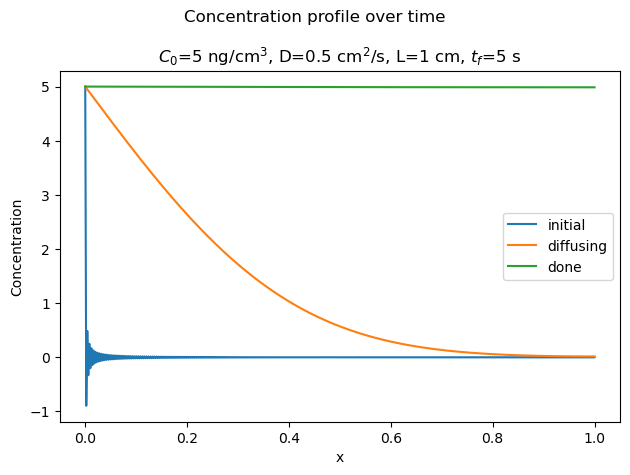

Total Solute:
t=0.00s: 0.0088
t=0.20s: 1.7876
t=2.50s: 4.8157
t=5.00s: 4.9915


In [ ]:
L = 1
tf = 5


x = jnp.linspace(0, L, C.shape[1])
dx = L/C.shape[1]
dt = tf/C.shape[0]

plt.plot(x, C[0], label='initial')
plt.plot(x, C[10], label = 'diffusing')
plt.plot(x, C[-1], label='done')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.suptitle(f"Concentration profile over time")
plt.title("$C_0$=5 ng/cm$^3$, D=0.5 cm$^2$/s, L=1 cm, $t_f$=5 s")
plt.legend()
plt.tight_layout()
plt.show()

print("Total Solute:")
print(f't=0.00s: {jnp.sum(C[0]*dx):.4f}')
print(f't={20*dt:.2f}s: {jnp.sum(C[20]*dx):.4f}')
print(f't={250*dt:.2f}s: {jnp.sum(C[250]*dx):.4f}')
print(f't=5.00s: {jnp.sum(C[-1]*dx):.4f}')

Text(0, 0.5, 'm')

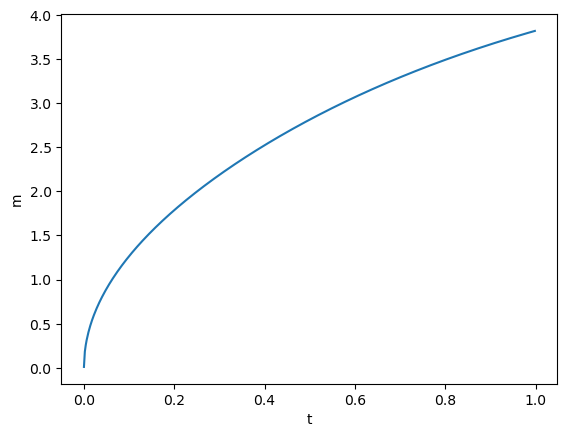

In [19]:
uptake_data = C_uptake(C)

plt.plot(uptake_data[0], uptake_data[1])

plt.xlabel('t')
plt.ylabel('m')



Text(0.5, 1.0, 'Mass Uptake over Time')

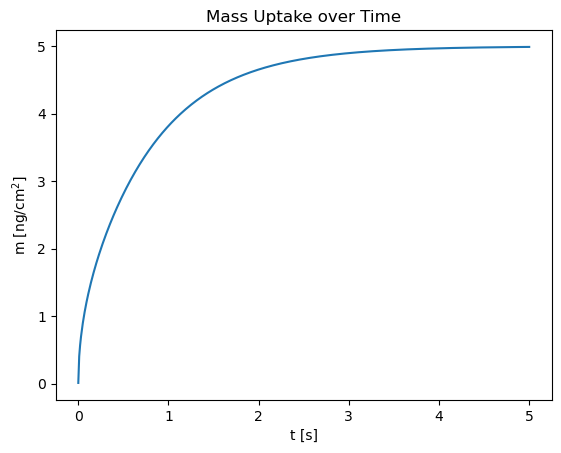

In [ ]:
C0 = 5
D = 0.5
L = 1
times = jnp.linspace(0, 5, 500)

uptake_data = an_uptake(C0, D, L, times)

plt.plot(times, uptake_data)
plt.xlabel('t [s]')
plt.ylabel('m [ng/cm$^2$]')
plt.title('Mass Uptake over Time')

As expected, mass uptake asymptotically approaches the maximum possible uptake, $C_0 \cdot L$. This is because the highest concentration profile possible is the steady state profile $C(x,t)=C_0$.

## Initial Conditions and Units

### Initial Conditions from Slides

*Assuming constant-D simple diffusion*, the uptake curve depends on three parameters:

- **Concentration of Solvent Drop:** From slides: "Loaded solution (50 μL, 2 mg/mL) is added to the existing solvent to introduce dopant which results in mass uptake in the film which we model with the Sauerbrey formula". Thus, $$C_{dopant} = 2 \text{ mg/mL} = 2 \text{ mg/cm}^3 = 2 \times 10^3 \text{ ng/cm}^3$$ 

- **Boundary concentration (C0):** A simple calculation shows that using the dopant concentration as $C_0$ produces far too small of a final uptake. This suggests that mass uptake is dominated by solvent diffusion into the film. Thus, the density of the solvent is used as the effective boundary concentration in units mass per unit volume.

    - The final steady-state uptake of the samples shows that solvent density is somewhat less than the density of water, $C_0 = 1 \text{ g/mL} = 1 \times 10^9 \text{ ng/cm}^3$. $$m_f = L \cdot C_0 \rightarrow C_0 = m_f/L$$
 
    - Because the units for $L$ [$\text{cm}$] and $t$ [$\text{s}$] cancel with the units of $D$ [$\text{cm}^2/\text{s}$], any units for concentration can be used.


- **Diffusion Coefficient (D):** This is the independant variable that must be determined via fitting. Measured in $\text{cm}^2/\text{s}$.

    - Values on the order of $10^{-12} \text{ cm}^2/\text{s}$ seem to be appropriate

- **Film Thickness (L):** Given per film in $[\text{\AA} = 10^{-8} \text{ cm}$ inside `QCMSummary.xlsx`.

### Units of Mass Uptake

- Measured in $\text{ng}/\text{cm}^2$ in the `.csv` files. 

- Calculated from $m(t) = \int{C(x, t) dx}$.

- Thus, we need initial concentration $C_0$ in $\text{ng/cm}^3$.


## Fitting Data to Analytic Uptake Curves

### Importing Thicknesses

In [39]:
thicknesses = pd.read_excel('./data/DopantUptake/DopantUptake/QCMSummary.xlsx', sheet_name='Thicknesses', index_col='Sample')

thicknesses

,Thickness [A]
Sample,
2,233.00000
15,205.75000
21,237.50000
22,282.25000
24,304.25000
39,257.00000
50,290.25000
53,234.50000
58,321.50000


### Sample 53

In [40]:
df = cropped_sample_dfs_first['Sample 53']

df = df[df['Time shifted [s]'] >= 0]

df

,Time [s],R1_m5 [ng/cm^2],C1_m [ng/cm^2],Time shifted [s]
4,755.6474,0.00,0.00,0.0000
5,756.0940,54.55,52.60,0.4466
6,756.4296,59.52,58.80,0.7822
7,756.8808,170.48,230.82,1.2334
8,757.3564,474.46,518.39,1.7090
9,757.9181,848.96,816.87,2.2707
10,758.6082,900.21,890.98,2.9608
11,759.1141,898.65,889.12,3.4667
12,759.4475,852.03,849.68,3.8001
13,759.8885,827.10,824.80,4.2411


### Finding an Appropriate C0, D

C:\Users\willi\AppData\Local\Temp\ipykernel_22608\42717009.py:11: UserWarning: Explicitly requested dtype float64 requested in full is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  C = jnp.full((Nt, Nx), C0, dtype='float')


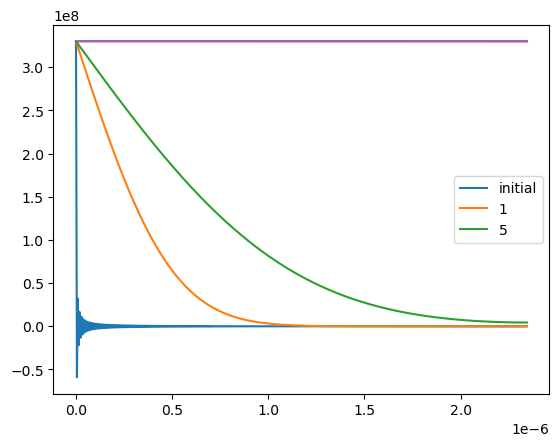

In [43]:
# Test plot

times = df['Time shifted [s]'] # [s]
m_exp = df['C1_m [ng/cm^2]']   # [ng/cm^2]


L = thicknesses.loc[53, 'Thickness [A]'] # [A]
L *= 1e-8 # [cm]

# Divide final uptake (assuming steady state reached) by the length to get assumed boundary concentration
C0 = m_exp.iloc[-1]/L # [ng/cm^3]

D = 5e-12 # [cm^2/s]

Nx = 500

tf = times.iloc[-1]

an_soln = analytic_grid(C0, D, L, tf, Nx=Nx)


x = np.linspace(0, L, Nx)

plt.plot(x, an_soln[0], label = 'initial')

plt.plot(x, an_soln[1], label = '1')

plt.plot(x, an_soln[5], label='5')

plt.plot(x, an_soln[250])

plt.plot(x, an_soln[-1])

plt.legend()


In [ ]:
print(f'Assumed boundary concentration: {C0:.2e} ng/cm^3')

# this is likely the density of the solvent
# Density of water is 1e9 ng/cm3

Assumed boundary concentration: 3.30e+08 ng/cm^3


### Plotting Uptake Curves for Different Values of Constant D

In [58]:
m_an = {}

for D in np.linspace(1e-15, 1e-12, 100):
    m_an[D] = an_uptake(C0, D, L, times)

m_an

{1e-15: [1.3625868480163568,
  8.64401782596359,
  11.180221294570094,
  13.835714336138508,
  16.145972783986217,
  18.490625356666914,
  21.002559175420892,
  22.661643868667618,
  23.689449095124317,
  24.982020823579436,
  26.194324711698815,
  27.368791857096976,
  28.508735190621096,
  29.58614775693934,
  30.69240701463876,
  31.813752330172544,
  32.864572445608125],
 1.109090909090909e-14: [1.3625868480163568,
  26.934711343726427,
  35.393029433879164,
  44.244172048351835,
  51.94247092158257,
  59.754192374831895,
  68.12239243049699,
  73.6490894744784,
  77.07278079110377,
  81.37833260781674,
  85.4164294747135,
  89.32842882296173,
  93.12537952598593,
  96.7140079011624,
  100.3986794156324,
  104.13356280997736,
  107.6335172352752],
 2.1181818181818178e-14: [1.3625868480163568,
  36.92410973574802,
  48.61401814595542,
  60.84650794481902,
  71.48560173115982,
  82.28136887494612,
  93.8461314186324,
  101.48394513683951,
  106.21542914593553,
  112.16562340266391,
 

In [ ]:
list(m_an.keys())[::20]

[1e-15,
 2.028181818181818e-13,
 4.046363636363636e-13,
 6.064545454545454e-13,
 8.082727272727272e-13]

In [47]:
list(m_an.items())[::20]

[(1e-15,
  [4.128784285564486,
   26.192301074925222,
   33.877269590085135,
   41.92369830500689,
   48.924029174890414,
   56.028577931753375,
   63.640006804964464,
   68.66721136067395,
   71.78157142791905,
   75.69820239216149,
   79.3716131915412,
   82.93037460252283,
   86.38452516088185,
   89.64920078824497,
   93.00128498427178,
   96.3990815535013,
   99.58317920267615]),
 (2.028181818181818e-13,
  [4.128784285564486,
   341.26938346592937,
   450.88441322305374,
   565.5881559948825,
   665.3642553355211,
   766.6353130317548,
   875.1464339297461,
   946.8021656746959,
   991.1660248146677,
   1046.8937541815108,
   1099.0476854298,
   1149.407713006109,
   1198.061047332119,
   1243.7688460199406,
   1290.340891508807,
   1337.0877009757771,
   1380.3898218855452]),
 (4.046363636363636e-13,
  [4.128784285564486,
   481.0633050201801,
   635.9061319902664,
   797.9888021090698,
   938.987011043248,
   1081.8058394925047,
   1233.431510825359,
   1331.770608891928,
   139

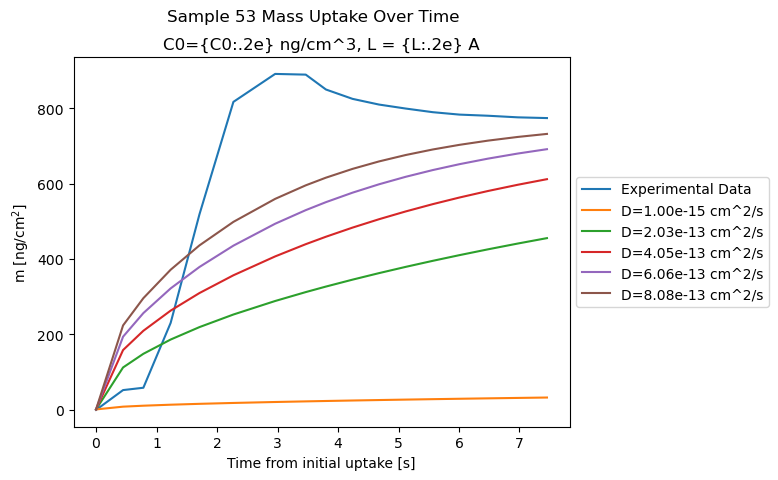

In [62]:
plt.plot(times, m_exp, label='Experimental Data')

for D, uptake in list(m_an.items())[::20]:

    plt.plot(times, uptake, label=f'D={D:.2e} cm^2/s')


plt.xlabel('Time from initial uptake [s]')
plt.ylabel('m [ng/cm$^2$]')

plt.suptitle('Sample 53 Mass Uptake Over Time')
plt.title('C0={C0:.2e} ng/cm^3, L = {L:.2e} A')

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

## Numerical Solution for Given Boundary Conditions

### Implementation

In [2]:
def num_grid(C0, D, k, L, tf, Nx=500, Nt=500):
    '''
    Uses Crank-Nicolson propagation to find concentration profile over time. 
    Allows for variable diffusion coeficient D(x).
    Includes explicit reaction term k.
    Uses earlier defined experimental boundary conditions.

    C0: Constant Dirichlet concentration at top boundary.
    D: diffusion coefficient D(x)
    k: reaction rate constant
    L: length of rod
    tf: final time
    Nx: Number of space steps. Including the 0th point, returns a matrix with dimention Nx+1.
    Nt: Number of time steps. Including the 0th point, returns a matrix with dimention Nt+1.
    x_scale: Optional rescale of x grid points.
    '''

    dt = tf/Nt # t_0 = 0, t_1 = dt, t_2 = 2*dt, ...,t_n = n*dt, t_Nt = Nt*dt = tf
    dx = L/Nx # x_0 = 0, x_1 = dx, x_2 = 2*dx, ..., x_i = i*dx, x_Nx = Nx*dx = L

    xgrid = np.linspace(0, L, Nx+1)
    Di = D(xgrid) # Discretizes D(x) to a vector of Nx+1 elements

    # Initialize diffusion ratios
    # r_alpha, r_beta differ by 1 index/1 element at each end.
    # r_ab[0] = 1/2 * (D0+D1)*dt / 2*dx^2 = r_alpha[0] = r_beta[1]
    r_ab = 0.5*(Di[:-1] + Di[1:])*dt / (2*dx**2) # Size (Nx,) 
    
    if k != 0 and dt > 2/k:
        tqdm.write(f"dt={dt:.5f} outside of stability conditions! (Nt={Nt}, k={k})")     

    A_bands = np.zeros((3,Nx+1))
    A_bands[0,1:] = -r_ab # Upper Diagonal: -r_alpha[0], -r_alpha[1], -r_alpha[2], ..., -r_alpha[Nx]
    A_bands[1,1:-1] = (1+r_ab[1:]+r_ab[:-1]) # Main Diagonal[i]: 1 + r_alpha[i] + r_alpha[i-1] = 1 + r_alpha[i] + r_beta[i]
    A_bands[1,0] = 1+2*r_ab[0] # Main diagonal endpoints (double r for conservation via ghost points)
    A_bands[1,-1] = 1+2*r_ab[-1]
    A_bands[2,:-1] = -r_ab # Lower Diagonal

    B_bands = np.zeros((3,Nx+1))
    B_bands[0,1:] = r_ab
    B_bands[1,1:-1] = (1-r_ab[1:]-r_ab[:-1])
    B_bands[1,0] = 1-2*r_ab[0]
    B_bands[1,-1] = 1-2*r_ab[-1]
    B_bands[2,:-1] = r_ab

    B = np.diag(B_bands[1,:]) + np.diag(B_bands[0,1:], k=+1) + np.diag(B_bands[2,:-1], k=-1)

    # Lext/top Dirichlet boundary condition:
    # Set first row as identity
    A_bands[0,1] = 0
    A_bands[1,0] = 1
    
    # Right/bottom Neumann boundary condition:
    # Double Endpoints value
    rN = r_ab[-1] # r_beta[Nx]
    A_bands[2,-2] = -2*rN # A[Nx, Nx-1] (A_bands[2,-1] is nonsense due to banded matrix format)
    B[-1,-2] = 2*rN


    C = np.empty((Nt+1, Nx+1)) # (n,i) from (0,0) to (Nt, Nx)
    C[0,:] = 0
    C[0,0] = C0 # Enforce Dirichlet BC at top


    for n in range(Nt):
        RHS = B@C[n] - dt*k*C[n]
        RHS[0]=C0
        C[n+1,:] =la.solve_banded((1,1), A_bands, RHS) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.

    return C

def num_uptake(C0, D, k, L, times, Nx=500, Nt=500):
    '''
    Uses Crank-Nicolson propagation to find concentration profile at a set of final times. 
    Manually recalculates for a series of final times.
    Allows for variable diffusion coeficient D(x).
    Includes explicit reaction term k.
    Uses earlier defined experimental boundary conditions.

    C0: Constant Dirichlet concentration at top boundary.
    D: diffusion coefficient D(x)
    k: reaction rate constant
    L: length of rod
    times: final times to calculate concentration profile at
    Nx: Number of space steps. Including the 0th point, returns a matrix with dimention Nx+1.
    Nt: Number of time steps. Including the 0th point, returns a matrix with dimention Nt+1.
    x_scale: Optional rescale of x grid points.
    '''

    dx = L/Nx # x_0 = 0, x_1 = dx, x_2 = 2*dx, ..., x_i = i*dx, x_Nx = Nx*dx = L
    Di = jnp.linspace(0, L, Nx+1)
    Di[:] = D(Di) # Discretizes D(x) to a vector of Nx+1 elements

    uptakes = []
    for tf in tqdm(times):

        dt = tf/Nt # t_0 = 0, t_1 = dt, t_2 = 2*dt, ...,t_n = n*dt, t_Nt = Nt*dt = tf
        
        # Initialize diffusion ratios
        # r_alpha, r_beta differ by 1 index/1 element at each end.
        # r_ab[0] = 1/2 * (D0+D1)*dt / 2*dx^2 = r_alpha[0] = r_beta[1]
        r_ab = 0.5*(Di[:-1] + Di[1:])*dt / (2*dx**2) # Size (Nx,) 
        
        if k != 0 and dt > 2/k:
            tqdm.write(f"dt={dt:.5f} outside of stability conditions! (Nt={Nt}, k={k})")     

        A_bands = jnp.zeros((3,Nx+1))
        A_bands[0,1:] = -r_ab # Upper Diagonal: -r_alpha[0], -r_alpha[1], -r_alpha[2], ..., -r_alpha[Nx]
        A_bands[1,1:-1] = (1+r_ab[1:]+r_ab[:-1]) # Main Diagonal[i]: 1 + r_alpha[i] + r_alpha[i-1] = 1 + r_alpha[i] + r_beta[i]
        A_bands[1,0] = 1+2*r_ab[0] # Main diagonal endpoints (double r for conservation via ghost points)
        A_bands[1,-1] = 1+2*r_ab[-1]
        A_bands[2,:-1] = -r_ab # Lower Diagonal

        B_bands = jnp.zeros((3,Nx+1))
        B_bands[0,1:] = r_ab
        B_bands[1,1:-1] = (1-r_ab[1:]-r_ab[:-1])
        B_bands[1,0] = 1-2*r_ab[0]
        B_bands[1,-1] = 1-2*r_ab[-1]
        B_bands[2,:-1] = r_ab

        B = jnp.diag(B_bands[1,:]) + jnp.diag(B_bands[0,1:], k=+1) + jnp.diag(B_bands[2,:-1], k=-1)

        # Lext/top Dirichlet boundary condition:
        # Set first row as identity
        A_bands[0,1] = 0
        A_bands[1,0] = 1
        
        # Right/bottom Neumann boundary condition:
        # Double Endpoints value
        rN = r_ab[-1] # r_beta[Nx]
        A_bands[2,-2] = -2*rN # A[Nx, Nx-1] (A_bands[2,-1] is nonsense due to banded matrix format)
        B[-1,-2] = 2*rN


        C = jnp.zeros(Nt+1) # Manually rewrites Ci(t) for each x_i from 0 to x_Nx.
        C[0] = C0 # Enforce Dirichlet BC at top

        for n in range(Nt):
            RHS = B@C - dt*k*C
            RHS[0] = C0
            C = la.solve_banded((1,1), A_bands, RHS) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.

        uptakes.append( jnp.sum(C*dx) ) # [ng/cm^2]

    return uptakes

In [ ]:
# Updated for JAX

def alt_num_uptake(C0, D, k, L, times, Nx=500, Nt=500):
    '''
    Uses Crank-Nicolson propagation to find concentration profile at a set of final times. 
    Manually recalculates for a series of final times.
    Allows for variable diffusion coeficient D(x).
    Includes explicit reaction term k.
    Uses earlier defined experimental boundary conditions.

    C0: Constant Dirichlet concentration at top boundary.
    D: diffusion coefficient D(x)
    k: reaction rate constant
    L: length of rod
    times: final times to calculate concentration profile at
    Nx: Number of space steps. Including the 0th point, returns a matrix with dimention Nx+1.
    Nt: Number of time steps. Including the 0th point, returns a matrix with dimention Nt+1.
    x_scale: Optional rescale of x grid points.
    '''

    dx = L/Nx # x_0 = 0, x_1 = dx, x_2 = 2*dx, ..., x_i = i*dx, x_Nx = Nx*dx = L
    xgrid = jnp.linspace(0, L, Nx+1)
    Di = D(xgrid) # Discretizes D(x) to a vector of Nx+1 elements

    uptakes = []
    for tf in tqdm(times):

        dt = tf/Nt # t_0 = 0, t_1 = dt, t_2 = 2*dt, ...,t_n = n*dt, t_Nt = Nt*dt = tf
        
        # Initialize diffusion ratios
        # r_alpha, r_beta differ by 1 index/1 element at each end.
        # r_ab[0] = 1/2 * (D0+D1)*dt / 2*dx^2 = r_alpha[0] = r_beta[1]
        r_ab = 0.5*(Di[:-1] + Di[1:])*dt / (2*dx**2) # Size (Nx,) 
        
        if k != 0 and dt > 2/k:
            tqdm.write(f"dt={dt:.5f} outside of stability conditions! (Nt={Nt}, k={k})")     

        A_bands = jnp.zeros((3,Nx+1))
        A_bands = A_bands.at[0,1:].set(-r_ab) # Upper Diagonal: -r_alpha[0], -r_alpha[1], -r_alpha[2], ..., -r_alpha[Nx]
        A_bands = A_bands.at[1,1:-1].set( (1+r_ab[1:]+r_ab[:-1]) ) # Main Diagonal[i]: 1 + r_alpha[i] + r_alpha[i-1] = 1 + r_alpha[i] + r_beta[i]
        A_bands = A_bands.at[1,0].set( 1+2*r_ab[0] ) # Main diagonal endpoints (double r for conservation via ghost points)
        A_bands = A_bands.at[1,-1].set( 1+2*r_ab[-1] )
        A_bands = A_bands.at[2,:-1].set( -r_ab ) # Lower Diagonal

        B_bands = jnp.zeros((3,Nx+1))
        B_bands = B_bands.at[0,1:].set(r_ab)
        B_bands = B_bands.at[1,1:-1].set( (1-r_ab[1:]-r_ab[:-1]) )
        B_bands = B_bands.at[1,0].set( 1-2*r_ab[0] )
        B_bands = B_bands.at[1,-1].set( 1-2*r_ab[-1] )
        B_bands = B_bands.at[2,:-1].set(r_ab)

        B = jnp.diag(B_bands[1,:]) + jnp.diag(B_bands[0,1:], k=+1) + jnp.diag(B_bands[2,:-1], k=-1)

        # Lext/top Dirichlet boundary condition:
        # Set first row as identity
        A_bands = A_bands.at[0,1].set(0)
        A_bands = A_bands.at[1,0].set(1)
        
        # Right/bottom Neumann boundary condition:
        # Double Endpoints value
        rN = r_ab[-1] # r_beta[Nx]
        A_bands = A_bands.at[2,-2].set(-2*rN) # A[Nx, Nx-1] (A_bands[2,-1] is nonsense due to banded matrix format)
        B = B.at[-1,-2].set(2*rN)

        # Extract diagonals for jax tridiagonal solver
        A_lower = A_bands[2,:-1] # In tridiagonal_solve, first element of lower diag is zero (reverse of scipy banded format)
        A_lower = jnp.concatenate([jnp.array([0]), A_lower])
        A_main  = A_bands[1,:]
        A_upper = A_bands[0,1:] # In tridiagonal_solve, last element of upper diag is zero (reverse of scipy banded format)
        A_upper = jnp.concatenate([A_upper, jnp.array([0])])

        # Initialize concentration array
        C = jnp.zeros(Nt+1) # Manually rewrites Ci(t) for each x_i from 0 to x_Nx.
        C = C.at[0].set(C0) # Enforce Dirichlet BC at top

        for n in range(Nt):
            RHS = B@C - dt*k*C
            RHS = RHS.at[0].set(C0)

            RHS_rank2 = RHS[:, None]  # Convert to column vector for jax

            C = tridiagonal_solve(A_lower, A_main, A_upper, RHS_rank2) # Set the solution to C[n+1], increment n and repeat 
            C = C.flatten()  # Convert back to 1D array

        uptakes.append( jnp.sum(C*dx) ) # [ng/cm^2]

    return uptakes

### Testing

In [4]:
C0 = 5
D = lambda x: np.cos(np.pi*x) + 1.5
k = 0
L = 1
tf = 5



C = num_grid(C0, D, k, L, tf)

In [5]:
C

array([[5.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+00, 9.82378738e+00, 9.65071565e+00, ...,
        7.75378743e-05, 7.73522966e-05, 7.72904654e-05],
       [5.00000000e+00, 1.76743353e-01, 3.47258708e-01, ...,
        9.94492487e-04, 9.92482455e-04, 9.91812683e-04],
       ...,
       [5.00000000e+00, 2.47227621e+00, 3.91149277e+00, ...,
        5.00000000e+00, 5.00000000e+00, 5.00000000e+00],
       [5.00000000e+00, 7.52587584e+00, 6.08642848e+00, ...,
        5.00000000e+00, 5.00000000e+00, 5.00000000e+00],
       [5.00000000e+00, 2.47596916e+00, 3.91564554e+00, ...,
        5.00000000e+00, 5.00000000e+00, 5.00000000e+00]], shape=(501, 501))

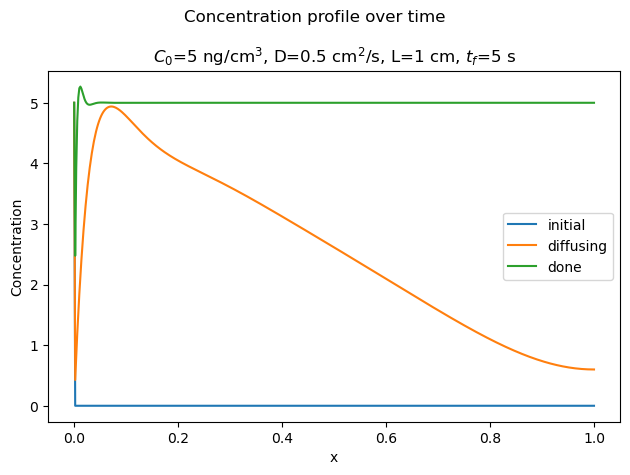

Total Solute:
t=0.00s: 0.0100
t=0.04s: 3.4460
t=0.50s: 4.9903
t=5.00s: 4.9943


In [6]:
L = 1
tf = 1


x = np.linspace(0, L, C.shape[1])
dx = L/C.shape[1]
dt = tf/C.shape[0]

plt.plot(x, C[0], label='initial')
plt.plot(x, C[10], label = 'diffusing')
plt.plot(x, C[-1], label='done')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.suptitle(f"Concentration profile over time")
plt.title("$C_0$=5 ng/cm$^3$, D=0.5 cm$^2$/s, L=1 cm, $t_f$=5 s")
plt.legend()
plt.tight_layout()
plt.show()

print("Total Solute:")
print(f't=0.00s: {np.sum(C[0]*dx):.4f}')
print(f't={20*dt:.2f}s: {np.sum(C[20]*dx):.4f}')
print(f't={250*dt:.2f}s: {np.sum(C[250]*dx):.4f}')
print(f't=5.00s: {np.sum(C[-1]*dx):.4f}')

In [ ]:
C0 = 5
D = lambda x: jnp.cos(np.pi*x/2) + 1.5
k = 0
L = 1
times = np.linspace(0, 5, 500)

num_uptake_data_500 = num_uptake(C0, D, k, L, times)
num_uptake_data_20 = num_uptake(C0, D, k, L, times, Nx=20, Nt=20)

# Continued...

  0%|          | 0/500 [00:01<?, ?it/s]


NameError: name 'tridiagonal_solve' is not defined

In [43]:
num_uptake_data_15 = alt_num_uptake(C0, D, k, L, times, Nx=15, Nt=15)

100%|██████████| 500/500 [00:19<00:00, 26.28it/s]


In [32]:
num_uptake_data_alt = alt_num_uptake(C0, D, k, L, times, Nx=20, Nt=20)
an_uptake_data = an_uptake(C0, D(0), L, times)

100%|██████████| 500/500 [00:13<00:00, 37.66it/s]
C:\Users\willi\AppData\Local\Temp\ipykernel_5220\42717009.py:38: UserWarning: Explicitly requested dtype float64 requested in full is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  C = jnp.full(Nx, C0, dtype='float')


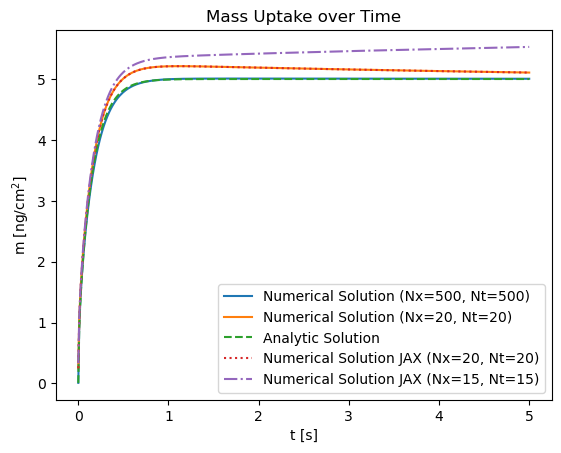

In [44]:

plt.plot(times, num_uptake_data_500, label='Numerical Solution (Nx=500, Nt=500)')
plt.plot(times, num_uptake_data_20, label='Numerical Solution (Nx=20, Nt=20)')
plt.plot(times, an_uptake_data, label='Analytic Solution', linestyle='--')
plt.plot(times, num_uptake_data_alt, label='Numerical Solution JAX (Nx=20, Nt=20)', linestyle=':')
plt.plot(times, num_uptake_data_15, label='Numerical Solution JAX (Nx=15, Nt=15)', linestyle='-.')
plt.xlabel('t [s]')
plt.ylabel('m [ng/cm$^2$]')
plt.title('Mass Uptake over Time')
plt.legend()

## Setting up a generic D(x) Spline

### Using Scipy (Doesn't work with Jax)

In [ ]:
def make_spline_sp(weights, L): 
    '''
    Makes a cubic B-spline from the given weights over the interval [0, L].
    Seems to work well with ~10 weights.
    Uses Scipy BSpline, not compatible with Jax
    '''
    k = 3                    
    n = len(weights)

    # clamped knot vector
    t = jnp.concatenate((
        jnp.zeros(k),
        jnp.linspace(0, L, n - k + 1),
        jnp.ones(k) * L
    ))

    spline = BSpline(t, weights, k)
    return spline

'''

### Jax-Friendly Spline

In [44]:
# Jax Version

def cubic_bspline(u):
    '''  
    For each input u, computes the cubic B-spline basis function value.
    '''
    absu = jnp.abs(u)
    return jnp.where(
        absu < 1,
        (4 - 6*absu**2 + 3*absu**3) / 6,
        jnp.where(
            absu < 2,
            (2 - absu)**3 / 6,
            0.0
        )
    )


def make_spline(weights, L, lin_weighting=1e-12, exp_weighting=1.0, median=0.0):
    '''  
    Makes a spline with the number of knots/nodes determined by how many weights are given.

    weights: array of shape (n,), containing values between 0 and 1
    L: length of the interval [0, L]
    
    Sums the piecewise basis functions defined in cubic_bspline, scaled by the weights.
    '''

    weights = jnp.asarray(weights)
    n = weights.shape[0]
    dx = L / (n - 1)
    x_nodes = jnp.linspace(0, L, n)

    if jnp.any(weights < 0) or jnp.any(weights > 1):
        raise ValueError("All weights must be between 0 and 1")

    adjusted_weights = median + (weights**exp_weighting) * lin_weighting
        

    def spline(x):
        u = (x[..., None] - x_nodes) / dx
        return jnp.sum(adjusted_weights * cubic_bspline(u), axis=-1)

    return jit(spline)


[0.67005379 0.24743131 0.01155097 0.29490733 0.36255478 0.95797184
 0.86109265 0.74937373 0.36396581 0.12492647]


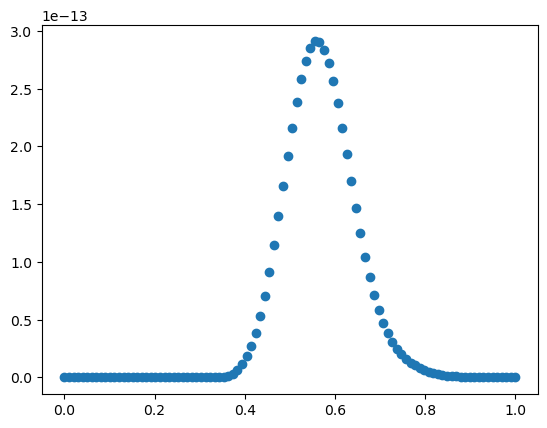

In [32]:
weights = np.random.rand(10)


f = make_spline(weights, L=1, lin_weighting=1e-12, exp_weighting=20)

x = np.linspace(0, 1, 100)

plt.plot(x, f(x), 'o')

print(weights)

[-2.8304616e-14  4.6713187e-13  2.9570297e-13  1.5354592e-13
 -1.2403282e-13  2.1692315e-13 -1.4408790e-12  7.5585989e-13
  5.2140963e-13  9.1017038e-13]


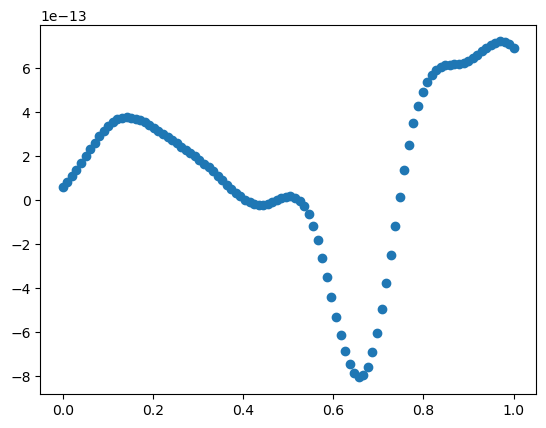

In [87]:
# More accurate numbers

key = jax.random.PRNGKey(42)
weights = jax.random.normal(key, (10,))*1e-12 # Scaled to order of 1e-12 [cm^2/s] diffusion coefficients

f = make_spline(weights, L=1)

x = np.linspace(0, 1, 100)

plt.plot(x, f(x), 'o')

print(weights)

## Testing Different D(x)

### Import Sample 53 df, Thickness, C0

In [67]:
# Sample 53
df = cropped_sample_dfs_first['Sample 53']
df = df[df['Time shifted [s]'] >= 0]

times = df['Time shifted [s]'] # [s]
m_exp = df['C1_m [ng/cm^2]']   # [ng/cm^2]

L = thicknesses.loc[53, 'Thickness [A]'] # [A]
L *= 1e-8 # [cm]

# Divide final uptake (assuming steady state reached) by the length to get assumed boundary concentration
C0 = m_exp.iloc[-1]/L # [ng/cm^3]

# No reaction term
k = 0

# Small N, slight innaccuracy
Nx = 20
Nt = 20

### Implementation

In [81]:
def L2norm(num_soln, an_soln):
    '''
    Computes the distance between "points" in the solution vector and analytic solution vector.
    This is normalized by the norm of the analytic solution.  
    '''
    if len(num_soln) != len(an_soln):
        raise ValueError(f"Vectors must be the same length (sizes {len(num_soln)} and {len(an_soln)}).")
    else:
        err = jnp.linalg.norm(num_soln - an_soln) / jnp.linalg.norm(an_soln)
    return err

def error(weights):
    '''  
    Makes a differentiable error function for jax.
    Uses many conditions defined above for Sample 53.
    D is defined by the spline made from the input weights.
    '''
    
    D = make_spline(weights, L)
    times = df['Time shifted [s]'] # [s]        //Restating just in case b/c elsewhere I change times variable
    m_num = alt_num_uptake(C0, D, k, L, times, Nx=15, Nt=15) 
    return L2norm(jnp.array(m_num), jnp.array(m_exp))

error_grad = jax.grad(error) # Should return a function that outputs the gradient vector of error(weights)

def grad_descent(weights, learning_rate=1e-3, num_steps=1000):
    '''
    Simple gradient descent optimizer.
    Should probably use less steps at least until more optimized.
    '''
    
    initial_weights = weights.copy() # Saves for later comparison

    for step in tqdm(range(num_steps)):
        grad_vector = error_grad(weights)
        weights = weights - learning_rate*grad_vector
        if step % 100 == 0:
            tqdm.write(f"Step {step}, Error: {error(weights):.6f}")
    return initial_weights, weights

### Calculating with Random Initial Weights

In [82]:
key = jax.random.PRNGKey(42)
weights = jax.random.normal(key, (10,))*1e-12 # Scaled to order of 1e-12 [cm^2/s] diffusion coefficients

initial_weights, optimized_weights = grad_descent(weights, learning_rate=1e-2, num_steps=30)

optimized_weights

  3%|▎         | 1/30 [00:06<03:13,  6.68s/it]

Step 0, Error: inf


100%|██████████| 30/30 [03:32<00:00,  7.08s/it]


Array([-2.8304616e-14,  4.6713187e-13,  2.9570297e-13,  1.5354592e-13,
       -1.2403282e-13,  2.1692315e-13, -1.4408790e-12,  7.5585989e-13,
        5.2140963e-13,  9.1017038e-13], dtype=float32)

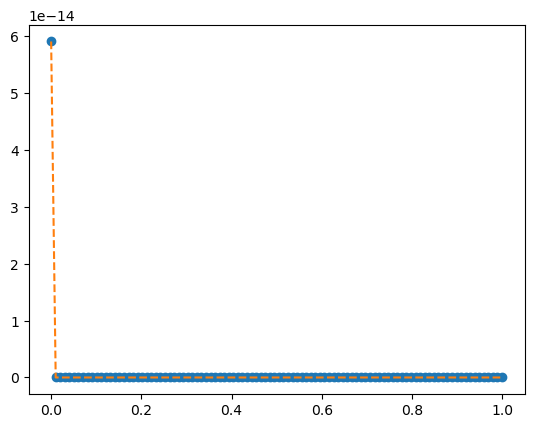

In [83]:
f = make_spline(weights, L)
f0 = make_spline(initial_weights, L)

x = np.linspace(0, 1, 100)

plt.plot(x, f(x), 'o', x, f0(x), '--')

In [84]:
D = f

fitted_uptake_data = num_uptake(C0, D, k, L, times, Nx=50, Nt=50)

100%|██████████| 17/17 [00:00<00:00, 827.76it/s]


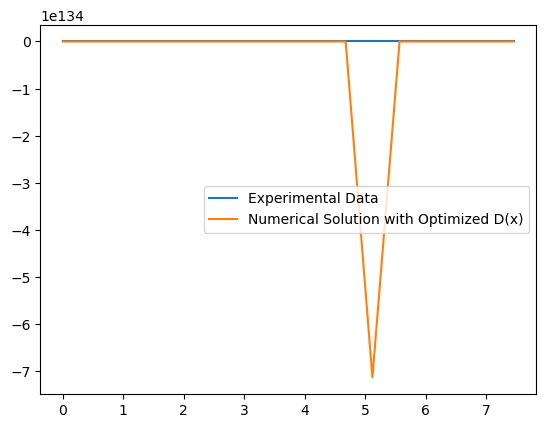

In [85]:
plt.plot(times, m_exp, label='Experimental Data')
plt.plot(times, fitted_uptake_data, label='Numerical Solution with Optimized D(x)')

plt.legend()

In [45]:
# exact test

weights = np.array([0.17868845, 0.01583082, 0.71467524, 0.56208104, 0.66165666, 0.86287856, 0.65813332, 0.61599403, 0.53966636, 0.93575107])
L = 250e-8
C0 = 1e9 #ng/mL

tf = 2

D = make_spline(weights, L=L)

k=0

C_profile = num_grid(C0, D, k, L, tf)

C_profile[-1,:]

array([1.00000000e+09, 9.91363734e+08, 9.82730212e+08, 9.74092783e+08,
       9.65445082e+08, 9.56781006e+08, 9.48095265e+08, 9.39382707e+08,
       9.30638686e+08, 9.21858875e+08, 9.13039454e+08, 9.04177203e+08,
       8.95269152e+08, 8.86312685e+08, 8.77305738e+08, 8.68246820e+08,
       8.59134858e+08, 8.49969218e+08, 8.40749915e+08, 8.31477548e+08,
       8.22153242e+08, 8.12779025e+08, 8.03357331e+08, 7.93891456e+08,
       7.84385319e+08, 7.74843479e+08, 7.65271312e+08, 7.55674932e+08,
       7.46061189e+08, 7.36437642e+08, 7.26812462e+08, 7.17194641e+08,
       7.07593697e+08, 6.98019697e+08, 6.88483109e+08, 6.78994877e+08,
       6.69566254e+08, 6.60208695e+08, 6.50933900e+08, 6.41753336e+08,
       6.32678478e+08, 6.23720426e+08, 6.14889922e+08, 6.06197313e+08,
       5.97652440e+08, 5.89264423e+08, 5.81041648e+08, 5.72991647e+08,
       5.65121262e+08, 5.57436332e+08, 5.49941740e+08, 5.42641501e+08,
       5.35538719e+08, 5.28635558e+08, 5.21933408e+08, 5.15432835e+08,
      

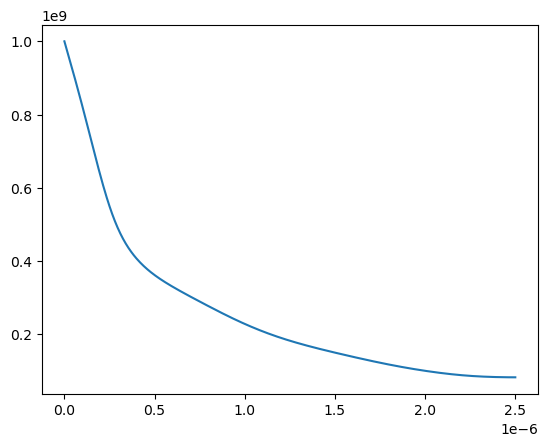

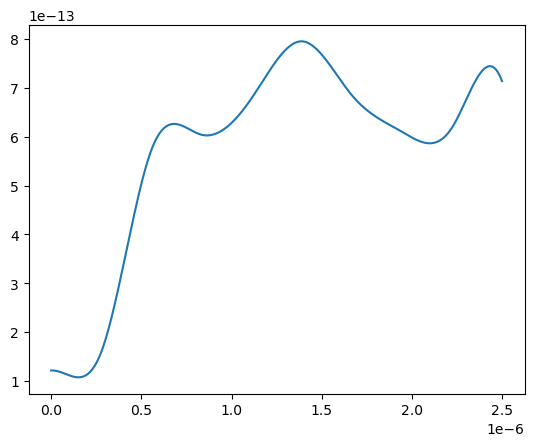

In [47]:
x = np.linspace(0, L, 501)

plt.plot(x, C_profile[-1,:])

plt.figure(2)

plt.plot(x, D(x))